# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

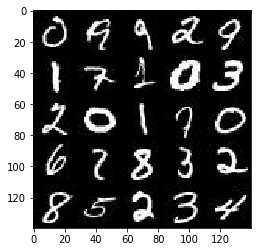

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

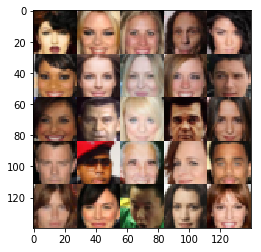

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    keep_prob = 0.7
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1, keep_prob, training=True)
        #14x14x64
        
        x2 = tf.layers.conv2d(x1, filters=128, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, keep_prob, training=True)
        #7x7x128
        
        x3 = tf.layers.conv2d(x2, filters=256, kernel_size=5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, keep_prob, training=True)
        #7x7x256
        
        flat = tf.reshape(x2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    z_dim = tf.shape(z)
    alpha = 0.01
    keep_prob = 0.5
    
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1, keep_prob, training=True)
        #7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, keep_prob, training=True)
        #14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x2, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, keep_prob, training=True)
        #28x28x128
        
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        #28x28xout_channel_dim
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [13]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate_scalar, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    import pickle as pkl
    
    # TODO: Build Model
    print_every = 10
    show_every = 100
    steps = 0
    n_images = 16
    inputs_real, inputs_z, learning_rate = model_inputs(data_shape[1], data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learning_rate: learning_rate_scalar})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learning_rate: learning_rate_scalar})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, inputs_z, data_shape[3], data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7751... Generator Loss: 1.6167
Epoch 1/2... Discriminator Loss: 0.8296... Generator Loss: 1.2114
Epoch 1/2... Discriminator Loss: 0.7064... Generator Loss: 2.0447
Epoch 1/2... Discriminator Loss: 0.9457... Generator Loss: 1.4120
Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 1.1822
Epoch 1/2... Discriminator Loss: 1.9059... Generator Loss: 1.1407
Epoch 1/2... Discriminator Loss: 1.4660... Generator Loss: 0.9871
Epoch 1/2... Discriminator Loss: 0.7240... Generator Loss: 1.7243
Epoch 1/2... Discriminator Loss: 1.1912... Generator Loss: 1.5366
Epoch 1/2... Discriminator Loss: 0.8218... Generator Loss: 1.5051


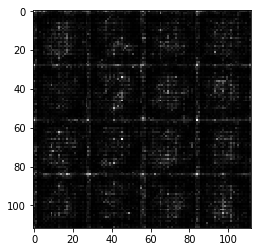

Epoch 1/2... Discriminator Loss: 0.5268... Generator Loss: 2.8082
Epoch 1/2... Discriminator Loss: 0.8776... Generator Loss: 1.7312
Epoch 1/2... Discriminator Loss: 0.9398... Generator Loss: 1.3832
Epoch 1/2... Discriminator Loss: 0.7741... Generator Loss: 2.2287
Epoch 1/2... Discriminator Loss: 0.6277... Generator Loss: 2.4252
Epoch 1/2... Discriminator Loss: 1.2261... Generator Loss: 2.4680
Epoch 1/2... Discriminator Loss: 0.9857... Generator Loss: 1.9776
Epoch 1/2... Discriminator Loss: 1.1092... Generator Loss: 1.7138
Epoch 1/2... Discriminator Loss: 0.9834... Generator Loss: 1.7332
Epoch 1/2... Discriminator Loss: 1.0509... Generator Loss: 1.8187


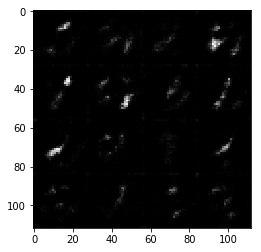

Epoch 1/2... Discriminator Loss: 1.5160... Generator Loss: 1.1797
Epoch 1/2... Discriminator Loss: 0.8219... Generator Loss: 1.7474
Epoch 1/2... Discriminator Loss: 0.7392... Generator Loss: 2.3645
Epoch 1/2... Discriminator Loss: 1.0024... Generator Loss: 2.1838
Epoch 1/2... Discriminator Loss: 1.4235... Generator Loss: 2.0852
Epoch 1/2... Discriminator Loss: 1.3123... Generator Loss: 1.2352
Epoch 1/2... Discriminator Loss: 0.8218... Generator Loss: 2.2949
Epoch 1/2... Discriminator Loss: 0.8991... Generator Loss: 2.6726
Epoch 1/2... Discriminator Loss: 0.8260... Generator Loss: 1.7315
Epoch 1/2... Discriminator Loss: 1.4627... Generator Loss: 0.8774


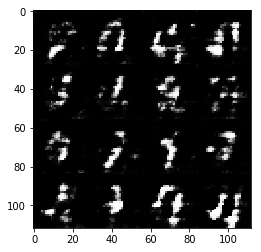

Epoch 1/2... Discriminator Loss: 1.0923... Generator Loss: 1.8023
Epoch 1/2... Discriminator Loss: 0.9726... Generator Loss: 1.5930
Epoch 1/2... Discriminator Loss: 1.3692... Generator Loss: 1.1871
Epoch 1/2... Discriminator Loss: 0.8112... Generator Loss: 1.6975
Epoch 1/2... Discriminator Loss: 0.9321... Generator Loss: 2.3774
Epoch 1/2... Discriminator Loss: 1.1322... Generator Loss: 0.8381
Epoch 1/2... Discriminator Loss: 0.8038... Generator Loss: 1.5289
Epoch 1/2... Discriminator Loss: 0.9035... Generator Loss: 1.3905
Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 1.1497
Epoch 1/2... Discriminator Loss: 1.4059... Generator Loss: 1.2343


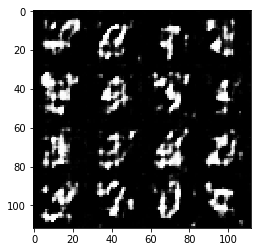

Epoch 1/2... Discriminator Loss: 1.4088... Generator Loss: 1.0638
Epoch 1/2... Discriminator Loss: 0.5993... Generator Loss: 1.4033
Epoch 1/2... Discriminator Loss: 1.0443... Generator Loss: 0.9895
Epoch 1/2... Discriminator Loss: 1.0468... Generator Loss: 1.8603
Epoch 1/2... Discriminator Loss: 1.4934... Generator Loss: 1.2763
Epoch 1/2... Discriminator Loss: 1.3886... Generator Loss: 0.6536
Epoch 1/2... Discriminator Loss: 0.7239... Generator Loss: 1.9629
Epoch 1/2... Discriminator Loss: 1.3559... Generator Loss: 1.5362
Epoch 1/2... Discriminator Loss: 1.0772... Generator Loss: 2.3852
Epoch 1/2... Discriminator Loss: 1.4250... Generator Loss: 1.7182


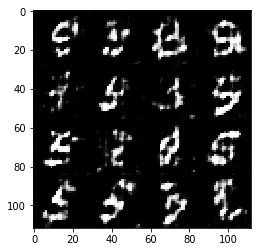

Epoch 1/2... Discriminator Loss: 0.9907... Generator Loss: 2.1723
Epoch 1/2... Discriminator Loss: 0.9156... Generator Loss: 2.6138
Epoch 1/2... Discriminator Loss: 0.7050... Generator Loss: 2.3703
Epoch 1/2... Discriminator Loss: 0.6871... Generator Loss: 2.3305
Epoch 1/2... Discriminator Loss: 0.9655... Generator Loss: 1.9705
Epoch 1/2... Discriminator Loss: 0.6381... Generator Loss: 1.0519
Epoch 1/2... Discriminator Loss: 0.7104... Generator Loss: 1.4241
Epoch 1/2... Discriminator Loss: 0.6333... Generator Loss: 1.4145
Epoch 1/2... Discriminator Loss: 0.6568... Generator Loss: 1.5071
Epoch 1/2... Discriminator Loss: 0.8327... Generator Loss: 1.9825


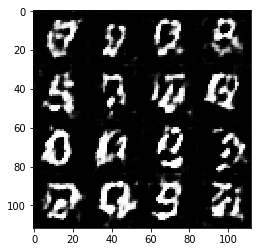

Epoch 1/2... Discriminator Loss: 0.7648... Generator Loss: 2.4543
Epoch 1/2... Discriminator Loss: 1.0000... Generator Loss: 1.8901
Epoch 1/2... Discriminator Loss: 0.5009... Generator Loss: 1.9627
Epoch 1/2... Discriminator Loss: 0.7589... Generator Loss: 1.0859
Epoch 1/2... Discriminator Loss: 0.7269... Generator Loss: 1.0059
Epoch 1/2... Discriminator Loss: 1.4439... Generator Loss: 0.4982
Epoch 1/2... Discriminator Loss: 0.4964... Generator Loss: 1.8596
Epoch 1/2... Discriminator Loss: 1.2430... Generator Loss: 1.7874
Epoch 1/2... Discriminator Loss: 0.7929... Generator Loss: 2.5425
Epoch 1/2... Discriminator Loss: 0.5724... Generator Loss: 1.4391


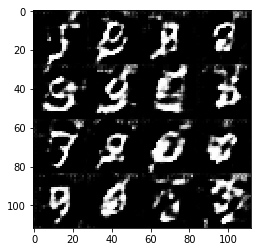

Epoch 1/2... Discriminator Loss: 1.1350... Generator Loss: 1.3945
Epoch 1/2... Discriminator Loss: 0.7743... Generator Loss: 2.1382
Epoch 1/2... Discriminator Loss: 0.5932... Generator Loss: 1.6132
Epoch 1/2... Discriminator Loss: 0.9260... Generator Loss: 1.9378
Epoch 1/2... Discriminator Loss: 0.8139... Generator Loss: 2.0248
Epoch 1/2... Discriminator Loss: 1.0457... Generator Loss: 0.9889
Epoch 1/2... Discriminator Loss: 0.5553... Generator Loss: 1.5251
Epoch 1/2... Discriminator Loss: 0.8412... Generator Loss: 1.5428
Epoch 1/2... Discriminator Loss: 1.2940... Generator Loss: 0.9657
Epoch 1/2... Discriminator Loss: 0.9046... Generator Loss: 1.3101


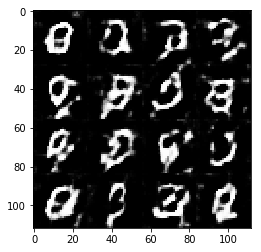

Epoch 1/2... Discriminator Loss: 0.6334... Generator Loss: 2.0716
Epoch 1/2... Discriminator Loss: 1.0124... Generator Loss: 1.0551
Epoch 1/2... Discriminator Loss: 0.5176... Generator Loss: 3.2559
Epoch 1/2... Discriminator Loss: 1.8110... Generator Loss: 3.7985
Epoch 1/2... Discriminator Loss: 0.5451... Generator Loss: 1.9929
Epoch 1/2... Discriminator Loss: 0.5007... Generator Loss: 2.2745
Epoch 1/2... Discriminator Loss: 0.5002... Generator Loss: 2.7773
Epoch 1/2... Discriminator Loss: 0.5447... Generator Loss: 2.8568
Epoch 1/2... Discriminator Loss: 0.8990... Generator Loss: 1.5544
Epoch 1/2... Discriminator Loss: 0.6602... Generator Loss: 1.2843


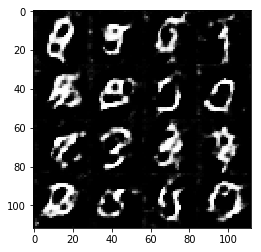

Epoch 1/2... Discriminator Loss: 1.1357... Generator Loss: 1.7479
Epoch 1/2... Discriminator Loss: 0.6886... Generator Loss: 1.1892
Epoch 1/2... Discriminator Loss: 1.2969... Generator Loss: 1.2712
Epoch 2/2... Discriminator Loss: 0.4271... Generator Loss: 2.6730
Epoch 2/2... Discriminator Loss: 1.1110... Generator Loss: 1.2940
Epoch 2/2... Discriminator Loss: 0.4915... Generator Loss: 3.0506
Epoch 2/2... Discriminator Loss: 0.4502... Generator Loss: 1.9024
Epoch 2/2... Discriminator Loss: 0.8536... Generator Loss: 1.2154
Epoch 2/2... Discriminator Loss: 0.6270... Generator Loss: 2.6112
Epoch 2/2... Discriminator Loss: 0.8961... Generator Loss: 3.1320


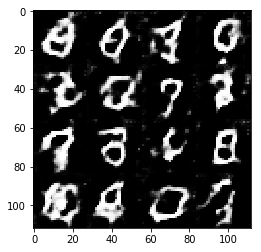

Epoch 2/2... Discriminator Loss: 0.7787... Generator Loss: 1.6848
Epoch 2/2... Discriminator Loss: 0.5002... Generator Loss: 1.9139
Epoch 2/2... Discriminator Loss: 0.9062... Generator Loss: 1.1165
Epoch 2/2... Discriminator Loss: 0.8579... Generator Loss: 2.3101
Epoch 2/2... Discriminator Loss: 0.8093... Generator Loss: 2.7535
Epoch 2/2... Discriminator Loss: 1.0235... Generator Loss: 1.6150
Epoch 2/2... Discriminator Loss: 0.7497... Generator Loss: 1.0786
Epoch 2/2... Discriminator Loss: 0.7063... Generator Loss: 3.3622
Epoch 2/2... Discriminator Loss: 0.7678... Generator Loss: 1.8111
Epoch 2/2... Discriminator Loss: 0.8615... Generator Loss: 3.2517


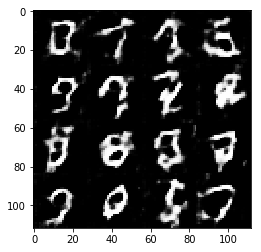

Epoch 2/2... Discriminator Loss: 0.9377... Generator Loss: 1.3168
Epoch 2/2... Discriminator Loss: 0.9604... Generator Loss: 2.3275
Epoch 2/2... Discriminator Loss: 0.6672... Generator Loss: 2.6011
Epoch 2/2... Discriminator Loss: 0.8171... Generator Loss: 2.3132
Epoch 2/2... Discriminator Loss: 0.6400... Generator Loss: 1.9364
Epoch 2/2... Discriminator Loss: 0.7822... Generator Loss: 1.0529
Epoch 2/2... Discriminator Loss: 0.7683... Generator Loss: 2.3054
Epoch 2/2... Discriminator Loss: 0.6306... Generator Loss: 3.7738
Epoch 2/2... Discriminator Loss: 0.7647... Generator Loss: 1.7866
Epoch 2/2... Discriminator Loss: 0.6972... Generator Loss: 1.4343


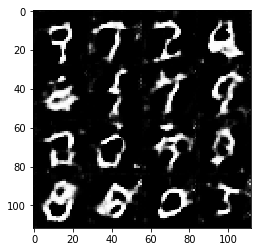

Epoch 2/2... Discriminator Loss: 0.8911... Generator Loss: 2.0511
Epoch 2/2... Discriminator Loss: 1.0579... Generator Loss: 1.6408
Epoch 2/2... Discriminator Loss: 0.8642... Generator Loss: 2.7322
Epoch 2/2... Discriminator Loss: 0.9644... Generator Loss: 2.5685
Epoch 2/2... Discriminator Loss: 0.5431... Generator Loss: 1.6457
Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 1.4788
Epoch 2/2... Discriminator Loss: 1.4212... Generator Loss: 3.0618
Epoch 2/2... Discriminator Loss: 0.9477... Generator Loss: 3.3961
Epoch 2/2... Discriminator Loss: 0.8931... Generator Loss: 2.1589
Epoch 2/2... Discriminator Loss: 0.8845... Generator Loss: 1.7872


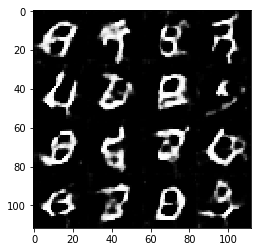

Epoch 2/2... Discriminator Loss: 0.5378... Generator Loss: 2.0287
Epoch 2/2... Discriminator Loss: 0.7789... Generator Loss: 1.8778
Epoch 2/2... Discriminator Loss: 0.7899... Generator Loss: 0.9385
Epoch 2/2... Discriminator Loss: 0.6210... Generator Loss: 1.1932
Epoch 2/2... Discriminator Loss: 0.9846... Generator Loss: 1.9492
Epoch 2/2... Discriminator Loss: 0.8137... Generator Loss: 2.0586
Epoch 2/2... Discriminator Loss: 0.6625... Generator Loss: 2.1313
Epoch 2/2... Discriminator Loss: 0.9905... Generator Loss: 3.1327
Epoch 2/2... Discriminator Loss: 1.3227... Generator Loss: 2.9462
Epoch 2/2... Discriminator Loss: 0.6198... Generator Loss: 1.8500


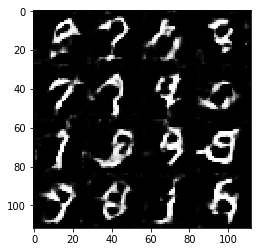

Epoch 2/2... Discriminator Loss: 0.6626... Generator Loss: 2.1406
Epoch 2/2... Discriminator Loss: 1.6628... Generator Loss: 0.4736
Epoch 2/2... Discriminator Loss: 0.7731... Generator Loss: 1.3222
Epoch 2/2... Discriminator Loss: 1.1040... Generator Loss: 0.5486
Epoch 2/2... Discriminator Loss: 1.0176... Generator Loss: 2.8663
Epoch 2/2... Discriminator Loss: 0.8562... Generator Loss: 2.1943
Epoch 2/2... Discriminator Loss: 1.3071... Generator Loss: 2.1160
Epoch 2/2... Discriminator Loss: 1.3381... Generator Loss: 2.8564
Epoch 2/2... Discriminator Loss: 0.6787... Generator Loss: 2.0210
Epoch 2/2... Discriminator Loss: 0.5024... Generator Loss: 2.8207


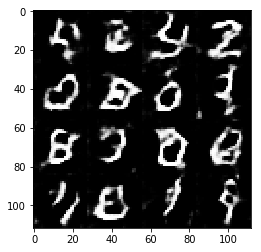

Epoch 2/2... Discriminator Loss: 1.0707... Generator Loss: 1.2112
Epoch 2/2... Discriminator Loss: 0.8587... Generator Loss: 1.1287
Epoch 2/2... Discriminator Loss: 0.8173... Generator Loss: 1.9850
Epoch 2/2... Discriminator Loss: 0.8447... Generator Loss: 2.2546
Epoch 2/2... Discriminator Loss: 1.3000... Generator Loss: 2.4304
Epoch 2/2... Discriminator Loss: 0.8254... Generator Loss: 1.4269
Epoch 2/2... Discriminator Loss: 1.0988... Generator Loss: 2.0346
Epoch 2/2... Discriminator Loss: 0.5523... Generator Loss: 2.1969
Epoch 2/2... Discriminator Loss: 0.7626... Generator Loss: 1.9170
Epoch 2/2... Discriminator Loss: 1.5293... Generator Loss: 1.0282


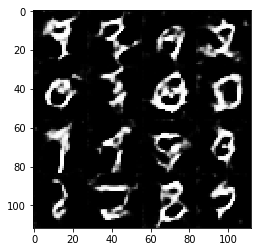

Epoch 2/2... Discriminator Loss: 0.8734... Generator Loss: 1.4292
Epoch 2/2... Discriminator Loss: 1.2832... Generator Loss: 2.1837
Epoch 2/2... Discriminator Loss: 0.8315... Generator Loss: 2.2979
Epoch 2/2... Discriminator Loss: 1.2758... Generator Loss: 1.0361
Epoch 2/2... Discriminator Loss: 0.5119... Generator Loss: 1.7211
Epoch 2/2... Discriminator Loss: 0.8383... Generator Loss: 0.9145
Epoch 2/2... Discriminator Loss: 1.4842... Generator Loss: 2.2275
Epoch 2/2... Discriminator Loss: 0.6319... Generator Loss: 1.5459
Epoch 2/2... Discriminator Loss: 0.7551... Generator Loss: 2.3008
Epoch 2/2... Discriminator Loss: 0.6933... Generator Loss: 0.9111


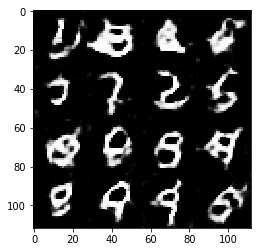

Epoch 2/2... Discriminator Loss: 1.5809... Generator Loss: 2.9280
Epoch 2/2... Discriminator Loss: 0.9783... Generator Loss: 1.2912
Epoch 2/2... Discriminator Loss: 0.7722... Generator Loss: 1.8204
Epoch 2/2... Discriminator Loss: 1.0975... Generator Loss: 1.0250
Epoch 2/2... Discriminator Loss: 0.7592... Generator Loss: 2.4374
Epoch 2/2... Discriminator Loss: 0.9955... Generator Loss: 1.9351
Epoch 2/2... Discriminator Loss: 0.5197... Generator Loss: 2.3829
Epoch 2/2... Discriminator Loss: 1.0736... Generator Loss: 1.5305
Epoch 2/2... Discriminator Loss: 0.9115... Generator Loss: 0.9404
Epoch 2/2... Discriminator Loss: 1.6881... Generator Loss: 2.5654


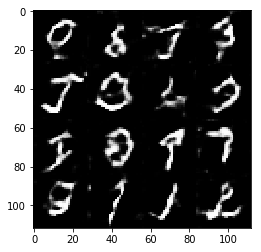

Epoch 2/2... Discriminator Loss: 0.8796... Generator Loss: 3.3588
Epoch 2/2... Discriminator Loss: 1.5783... Generator Loss: 0.8739
Epoch 2/2... Discriminator Loss: 1.2373... Generator Loss: 1.7671
Epoch 2/2... Discriminator Loss: 0.9077... Generator Loss: 1.0594
Epoch 2/2... Discriminator Loss: 0.6245... Generator Loss: 0.5774
Epoch 2/2... Discriminator Loss: 1.0740... Generator Loss: 1.9263
Epoch 2/2... Discriminator Loss: 0.4791... Generator Loss: 1.4435


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6491... Generator Loss: 2.0674
Epoch 1/1... Discriminator Loss: 0.4933... Generator Loss: 2.3104
Epoch 1/1... Discriminator Loss: 0.6405... Generator Loss: 2.0587
Epoch 1/1... Discriminator Loss: 0.6210... Generator Loss: 2.3915
Epoch 1/1... Discriminator Loss: 0.4797... Generator Loss: 3.3819
Epoch 1/1... Discriminator Loss: 0.4772... Generator Loss: 2.2880
Epoch 1/1... Discriminator Loss: 0.3930... Generator Loss: 2.5455
Epoch 1/1... Discriminator Loss: 0.5020... Generator Loss: 2.7376
Epoch 1/1... Discriminator Loss: 0.5176... Generator Loss: 3.5904
Epoch 1/1... Discriminator Loss: 0.3644... Generator Loss: 3.5322


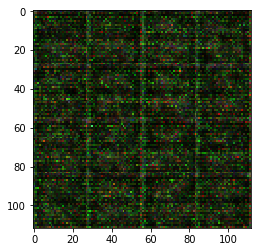

Epoch 1/1... Discriminator Loss: 0.2550... Generator Loss: 3.3477
Epoch 1/1... Discriminator Loss: 0.2441... Generator Loss: 2.4305
Epoch 1/1... Discriminator Loss: 0.1914... Generator Loss: 3.6913
Epoch 1/1... Discriminator Loss: 0.3204... Generator Loss: 3.4812
Epoch 1/1... Discriminator Loss: 0.1639... Generator Loss: 5.0259
Epoch 1/1... Discriminator Loss: 0.2850... Generator Loss: 3.0005
Epoch 1/1... Discriminator Loss: 0.0444... Generator Loss: 5.6620
Epoch 1/1... Discriminator Loss: 0.1151... Generator Loss: 3.7224
Epoch 1/1... Discriminator Loss: 0.0781... Generator Loss: 4.2547
Epoch 1/1... Discriminator Loss: 0.0408... Generator Loss: 5.5129


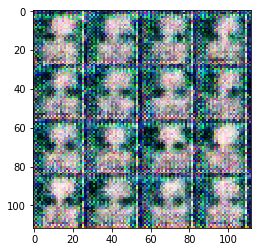

Epoch 1/1... Discriminator Loss: 0.1194... Generator Loss: 4.3547
Epoch 1/1... Discriminator Loss: 0.3030... Generator Loss: 4.6189
Epoch 1/1... Discriminator Loss: 0.0760... Generator Loss: 4.2618
Epoch 1/1... Discriminator Loss: 0.1693... Generator Loss: 4.0845
Epoch 1/1... Discriminator Loss: 0.0782... Generator Loss: 4.7973
Epoch 1/1... Discriminator Loss: 0.0572... Generator Loss: 4.2652
Epoch 1/1... Discriminator Loss: 0.0280... Generator Loss: 6.0254
Epoch 1/1... Discriminator Loss: 0.0407... Generator Loss: 5.6261
Epoch 1/1... Discriminator Loss: 0.1430... Generator Loss: 5.2274
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 9.5938


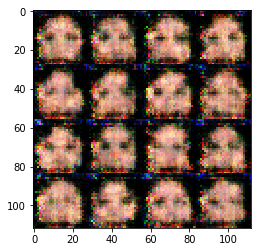

Epoch 1/1... Discriminator Loss: 0.1401... Generator Loss: 4.0641
Epoch 1/1... Discriminator Loss: 0.1955... Generator Loss: 5.1350
Epoch 1/1... Discriminator Loss: 0.1047... Generator Loss: 5.2856
Epoch 1/1... Discriminator Loss: 0.1914... Generator Loss: 3.5862
Epoch 1/1... Discriminator Loss: 0.1290... Generator Loss: 4.5787
Epoch 1/1... Discriminator Loss: 0.1699... Generator Loss: 4.4757
Epoch 1/1... Discriminator Loss: 0.1746... Generator Loss: 4.6747
Epoch 1/1... Discriminator Loss: 0.1099... Generator Loss: 4.0198
Epoch 1/1... Discriminator Loss: 0.1416... Generator Loss: 4.4752
Epoch 1/1... Discriminator Loss: 0.2499... Generator Loss: 3.6601


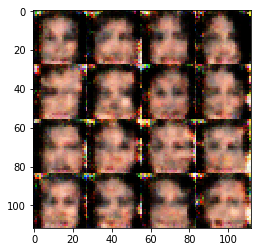

Epoch 1/1... Discriminator Loss: 0.5168... Generator Loss: 2.1135
Epoch 1/1... Discriminator Loss: 0.2279... Generator Loss: 3.8880
Epoch 1/1... Discriminator Loss: 0.5987... Generator Loss: 3.7620
Epoch 1/1... Discriminator Loss: 0.3161... Generator Loss: 1.7107
Epoch 1/1... Discriminator Loss: 1.8162... Generator Loss: 4.0481
Epoch 1/1... Discriminator Loss: 0.3194... Generator Loss: 4.4707
Epoch 1/1... Discriminator Loss: 0.0743... Generator Loss: 5.6497
Epoch 1/1... Discriminator Loss: 0.3845... Generator Loss: 2.5645
Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 1.3271
Epoch 1/1... Discriminator Loss: 0.6558... Generator Loss: 2.2541


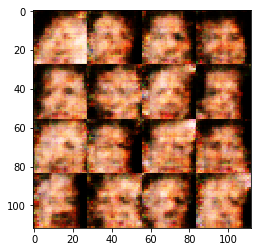

Epoch 1/1... Discriminator Loss: 0.7246... Generator Loss: 6.1172
Epoch 1/1... Discriminator Loss: 0.4740... Generator Loss: 3.2802
Epoch 1/1... Discriminator Loss: 0.4325... Generator Loss: 2.5281
Epoch 1/1... Discriminator Loss: 0.7151... Generator Loss: 4.1591
Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 5.2082
Epoch 1/1... Discriminator Loss: 0.7136... Generator Loss: 1.9296
Epoch 1/1... Discriminator Loss: 0.4943... Generator Loss: 4.3471
Epoch 1/1... Discriminator Loss: 1.8038... Generator Loss: 0.2816
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 2.7678
Epoch 1/1... Discriminator Loss: 0.1688... Generator Loss: 4.3689


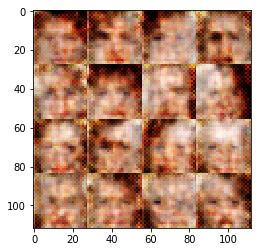

Epoch 1/1... Discriminator Loss: 0.8521... Generator Loss: 1.2857
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 1.7263
Epoch 1/1... Discriminator Loss: 0.3365... Generator Loss: 4.2095
Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 1.2912
Epoch 1/1... Discriminator Loss: 1.7407... Generator Loss: 3.1975
Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 1.6279
Epoch 1/1... Discriminator Loss: 0.1935... Generator Loss: 3.9250
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 3.1123
Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 3.0314
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 3.1843


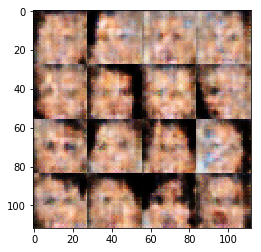

Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 2.5913
Epoch 1/1... Discriminator Loss: 0.2602... Generator Loss: 3.8988
Epoch 1/1... Discriminator Loss: 0.2586... Generator Loss: 3.7582
Epoch 1/1... Discriminator Loss: 0.4373... Generator Loss: 2.1353
Epoch 1/1... Discriminator Loss: 0.8176... Generator Loss: 1.3077
Epoch 1/1... Discriminator Loss: 0.8154... Generator Loss: 2.1552
Epoch 1/1... Discriminator Loss: 0.6294... Generator Loss: 2.4407
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 1.4516
Epoch 1/1... Discriminator Loss: 0.2637... Generator Loss: 3.1155
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 3.2210


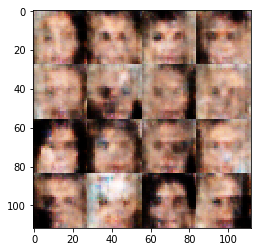

Epoch 1/1... Discriminator Loss: 0.4095... Generator Loss: 3.5132
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 2.9432
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 1.4236
Epoch 1/1... Discriminator Loss: 0.4074... Generator Loss: 1.5805
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 3.2797
Epoch 1/1... Discriminator Loss: 0.2704... Generator Loss: 3.3142
Epoch 1/1... Discriminator Loss: 0.5473... Generator Loss: 2.0399
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 0.5759... Generator Loss: 1.7996
Epoch 1/1... Discriminator Loss: 0.9118... Generator Loss: 1.5117


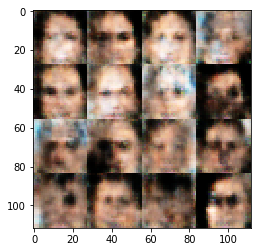

Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 1.2255
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 3.4234
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 1.4197
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 1.7940
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 1.2051
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 2.3549
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 1.8589
Epoch 1/1... Discriminator Loss: 0.4019... Generator Loss: 2.8951
Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 1.9015
Epoch 1/1... Discriminator Loss: 0.6992... Generator Loss: 2.0639


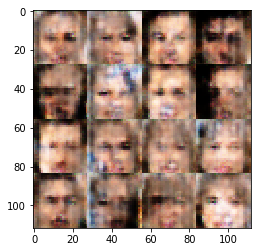

Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 1.4107
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 1.3247
Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 2.4615
Epoch 1/1... Discriminator Loss: 0.7566... Generator Loss: 2.0535
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 1.6067
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 1.1593
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 1.5842
Epoch 1/1... Discriminator Loss: 0.6664... Generator Loss: 1.6933


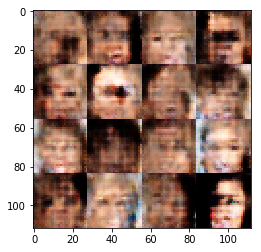

Epoch 1/1... Discriminator Loss: 0.6212... Generator Loss: 1.4498
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 1.9478
Epoch 1/1... Discriminator Loss: 0.3615... Generator Loss: 2.8443
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 5.2091
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 2.1656
Epoch 1/1... Discriminator Loss: 0.6698... Generator Loss: 1.9898
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 1.6412
Epoch 1/1... Discriminator Loss: 0.8879... Generator Loss: 2.7238
Epoch 1/1... Discriminator Loss: 0.5866... Generator Loss: 2.8659
Epoch 1/1... Discriminator Loss: 0.8880... Generator Loss: 2.1197


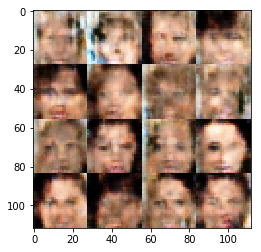

Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 1.9071
Epoch 1/1... Discriminator Loss: 0.2783... Generator Loss: 3.7587
Epoch 1/1... Discriminator Loss: 0.4645... Generator Loss: 2.8544
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 1.3342
Epoch 1/1... Discriminator Loss: 1.6464... Generator Loss: 4.5245
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 1.8763
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 0.8482... Generator Loss: 2.5064
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 1.3656
Epoch 1/1... Discriminator Loss: 0.5500... Generator Loss: 2.2169


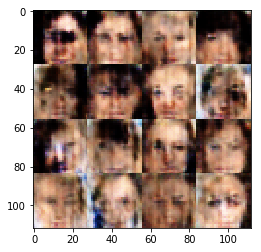

Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 1.6563
Epoch 1/1... Discriminator Loss: 0.6388... Generator Loss: 1.8135
Epoch 1/1... Discriminator Loss: 0.5494... Generator Loss: 2.4242
Epoch 1/1... Discriminator Loss: 0.6585... Generator Loss: 3.0899
Epoch 1/1... Discriminator Loss: 0.6834... Generator Loss: 3.2022
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 1.8935
Epoch 1/1... Discriminator Loss: 0.4011... Generator Loss: 2.5901
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 2.5192
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 1.2625
Epoch 1/1... Discriminator Loss: 0.3149... Generator Loss: 5.6508


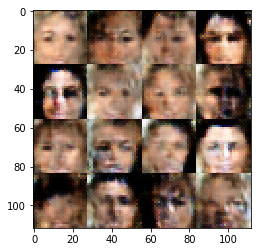

Epoch 1/1... Discriminator Loss: 0.6679... Generator Loss: 1.4877
Epoch 1/1... Discriminator Loss: 0.4439... Generator Loss: 3.9388
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 1.1827
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 2.5192
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 2.4697
Epoch 1/1... Discriminator Loss: 0.5805... Generator Loss: 2.9096
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 2.0508
Epoch 1/1... Discriminator Loss: 0.8993... Generator Loss: 3.5509
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 1.7585


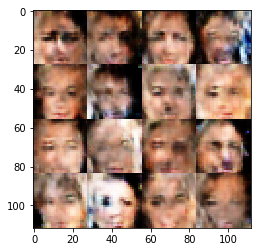

Epoch 1/1... Discriminator Loss: 0.7702... Generator Loss: 2.8209
Epoch 1/1... Discriminator Loss: 0.8467... Generator Loss: 2.6873
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 1.6921
Epoch 1/1... Discriminator Loss: 0.6904... Generator Loss: 2.1052
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 1.3703
Epoch 1/1... Discriminator Loss: 0.5999... Generator Loss: 1.8933
Epoch 1/1... Discriminator Loss: 0.8915... Generator Loss: 1.7389
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 1.6271
Epoch 1/1... Discriminator Loss: 0.7893... Generator Loss: 1.9420
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 2.3405


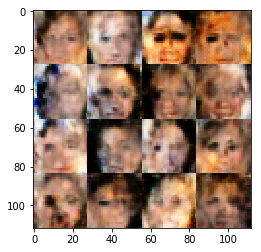

Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 1.7414
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 2.0286
Epoch 1/1... Discriminator Loss: 0.7328... Generator Loss: 2.4255
Epoch 1/1... Discriminator Loss: 2.8172... Generator Loss: 0.2476
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 1.7787
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 1.8113
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 0.7252... Generator Loss: 1.4364
Epoch 1/1... Discriminator Loss: 0.8107... Generator Loss: 2.8350


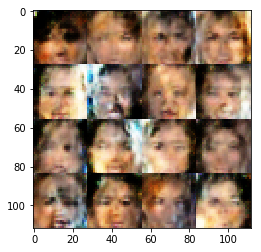

Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 1.4538
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 1.3892
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 1.2915
Epoch 1/1... Discriminator Loss: 0.6656... Generator Loss: 2.4469
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.6894
Epoch 1/1... Discriminator Loss: 0.3652... Generator Loss: 3.6467
Epoch 1/1... Discriminator Loss: 0.7220... Generator Loss: 1.3537
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 0.4375... Generator Loss: 1.9946
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 1.6003


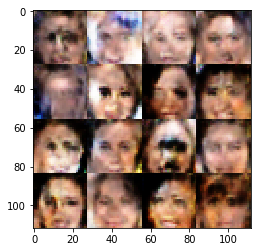

Epoch 1/1... Discriminator Loss: 0.6164... Generator Loss: 1.5263
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 3.5281
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 0.5393... Generator Loss: 1.5642
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 1.2104
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 1.4835
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 1.9973
Epoch 1/1... Discriminator Loss: 0.6414... Generator Loss: 2.4375


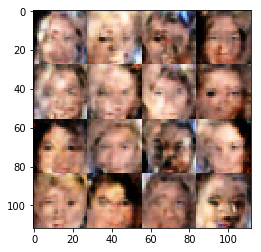

Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 1.2593
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 1.7024
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 0.6900... Generator Loss: 2.8215
Epoch 1/1... Discriminator Loss: 0.7635... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 2.5936
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 1.2394


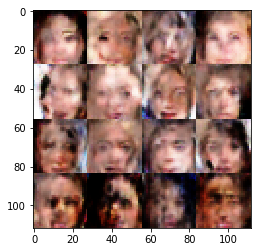

Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 1.4967
Epoch 1/1... Discriminator Loss: 0.8046... Generator Loss: 1.9821
Epoch 1/1... Discriminator Loss: 0.5614... Generator Loss: 5.1192
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 1.4384
Epoch 1/1... Discriminator Loss: 0.3234... Generator Loss: 4.1443
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 1.6654
Epoch 1/1... Discriminator Loss: 2.2562... Generator Loss: 1.2183
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 1.2662
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 1.6279
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 1.4951


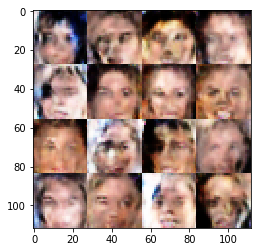

Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 1.2725
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 0.7631... Generator Loss: 2.0399
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 2.0666
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 1.5366
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 1.7590


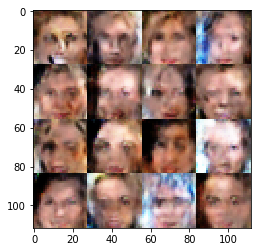

Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 1.6258
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 0.5316... Generator Loss: 3.1169
Epoch 1/1... Discriminator Loss: 0.8567... Generator Loss: 1.8999
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 2.0787
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 1.5693
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 2.0227
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 2.0609
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.5245


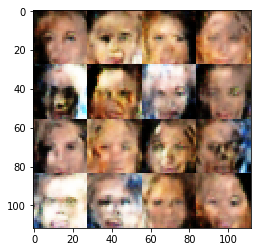

Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 1.5085
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 1.1758
Epoch 1/1... Discriminator Loss: 0.6078... Generator Loss: 2.3585
Epoch 1/1... Discriminator Loss: 0.8301... Generator Loss: 1.3619
Epoch 1/1... Discriminator Loss: 0.5155... Generator Loss: 1.9772
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 0.4564... Generator Loss: 2.7607
Epoch 1/1... Discriminator Loss: 0.6681... Generator Loss: 1.7091
Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 1.5609
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.1406


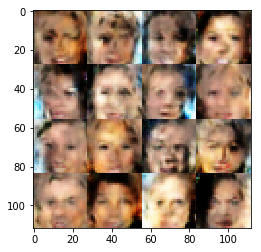

Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 1.6171
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 2.1868
Epoch 1/1... Discriminator Loss: 0.9324... Generator Loss: 2.0805
Epoch 1/1... Discriminator Loss: 1.7567... Generator Loss: 2.1655
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 1.4848
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 2.1583
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 0.3102... Generator Loss: 5.5589
Epoch 1/1... Discriminator Loss: 0.9136... Generator Loss: 1.6439


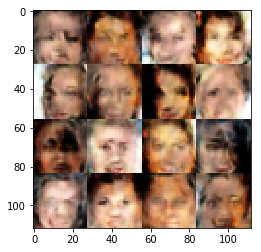

Epoch 1/1... Discriminator Loss: 0.8154... Generator Loss: 1.3475
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 2.3861
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 1.4467
Epoch 1/1... Discriminator Loss: 0.2817... Generator Loss: 4.0327
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 1.9242
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.2599
Epoch 1/1... Discriminator Loss: 0.7182... Generator Loss: 1.5979
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 1.4342


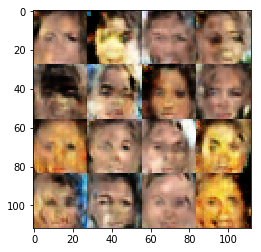

Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.6024
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.3383
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 1.5804
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 1.2376
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 1.5295
Epoch 1/1... Discriminator Loss: 0.3850... Generator Loss: 2.3590
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 1.9254
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 1.7493
Epoch 1/1... Discriminator Loss: 0.6624... Generator Loss: 2.6903
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 1.4530


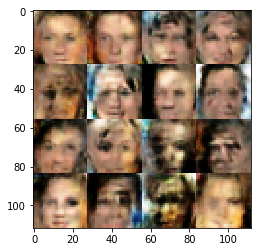

Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.9137
Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 1.4418
Epoch 1/1... Discriminator Loss: 0.6973... Generator Loss: 2.7653
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 1.3544
Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 1.2848
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 1.5236
Epoch 1/1... Discriminator Loss: 0.1381... Generator Loss: 4.1863


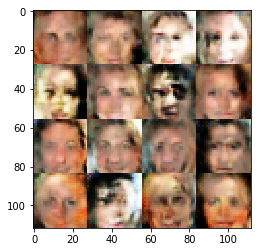

Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.5352
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 1.0201
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 1.1735
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 1.4893
Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 1.8990
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 2.5801
Epoch 1/1... Discriminator Loss: 0.3754... Generator Loss: 1.9952
Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 0.8393


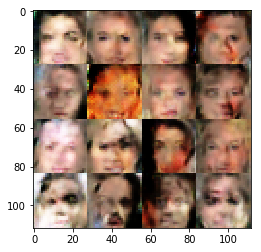

Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 1.0855
Epoch 1/1... Discriminator Loss: 0.7636... Generator Loss: 1.2899
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 0.7791... Generator Loss: 1.5962
Epoch 1/1... Discriminator Loss: 0.7763... Generator Loss: 2.7661
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 1.4749
Epoch 1/1... Discriminator Loss: 0.6613... Generator Loss: 2.3684
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 0.9231
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 1.6871
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 1.4834


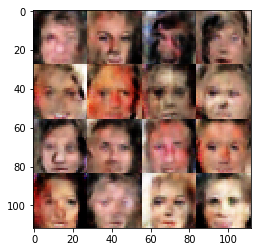

Epoch 1/1... Discriminator Loss: 1.8186... Generator Loss: 2.8420
Epoch 1/1... Discriminator Loss: 1.6008... Generator Loss: 1.2410
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.1175
Epoch 1/1... Discriminator Loss: 0.8156... Generator Loss: 2.2958
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 1.2269
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 1.9410
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 1.7864
Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 2.0278
Epoch 1/1... Discriminator Loss: 0.9918... Generator Loss: 1.5118
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 1.3776


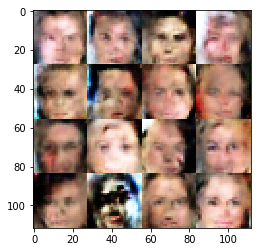

Epoch 1/1... Discriminator Loss: 0.7383... Generator Loss: 2.1435
Epoch 1/1... Discriminator Loss: 0.5318... Generator Loss: 1.9752
Epoch 1/1... Discriminator Loss: 0.8956... Generator Loss: 1.5170
Epoch 1/1... Discriminator Loss: 0.7511... Generator Loss: 1.9468
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 1.8889
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 2.7474


In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.